##Import various python functions and modules that we need.

In [1]:
from pandas import DataFrame
from IPython.display import FileLink

##Pylab namespace and inline plots. Import Rmagic.

In [2]:
%matplotlib inline
%load_ext rpy2.ipython

In [3]:
%%R
workDir = '/home/chantal/Chazy/data/'
figDir = '/home/chantal/Chazy/BulkSIP/515_806/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqBulk = 'bulk-core-rare'


nprocs = 20

##Import R libraries we'll use.

In [4]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(vegan)
library(plyr)
library(dplyr)
library(RColorBrewer)
library(stats)
library(stringr)
library(ape)
library(reshape2)
library(tidyr)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: iterators

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: parallel

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: permute

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: lattic

## Import data into R. Prune to relevant samples (Chazy)

In [5]:
%%R

F = file.path(physeqDir, physeqBulk)
physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
#physeq.Bulk = physeq.Bulk %>% filter_taxa(function(x) sum(x) > 0, TRUE) %>%
 #                           transform_sample_counts(function(x) x/sum(x))
#physeq.Bulk.Sparsity = filter_taxa(physeq.Bulk, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)

physeq.Bulk.m = physeq.Bulk %>% sample_data

physeq.Bulk.core = prune_samples(physeq.Bulk.m$Land_Management != "PAS",
                           physeq.Bulk)

print(physeq.Bulk.core)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 19331 taxa and 175 samples ]
sample_data() Sample Data:       [ 175 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 19331 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 19331 tips and 19330 internal nodes ]


In [6]:
%%R
physeq.Bulk.core.r.filt = physeq.Bulk.core %>% filter_taxa(function(x) sum(x) > 0, TRUE) %>%
                            transform_sample_counts(function(x) x/sum(x))
physeq.Bulk.core.RFN = filter_taxa(physeq.Bulk.core.r.filt, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)
    
physeq.Bulk.core.RFN
                      

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3964 taxa and 175 samples ]
sample_data() Sample Data:       [ 175 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 3964 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3964 tips and 3963 internal nodes ]


### Calculate Unifrac distances between samples (core only)

In [7]:
%%R
registerDoParallel(cores=20)
wunif.dist = distance(physeq.Bulk.core.RFN, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [8]:
%%R
# Removing samples w/o soil temperature

physeq.Bulk.m = physeq.Bulk.core.RFN %>% sample_data

physeq.notemp = prune_samples(!(is.na(physeq.Bulk.m$Soil_Temp)), physeq.Bulk.core.RFN)

physeq.notemp 

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3964 taxa and 127 samples ]
sample_data() Sample Data:       [ 127 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 3964 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3964 tips and 3963 internal nodes ]


In [9]:
%%R
registerDoParallel(cores=20)
wunif.dist.notemp = distance(physeq.notemp, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [10]:
%%R
# Removing samples w/o soil moisture
physeq.Bulk.m = physeq.Bulk.core.RFN %>% sample_data

physeq.nomoist = prune_samples(!(is.na(physeq.Bulk.m$Soil_Moisture)), physeq.Bulk.core.RFN)

physeq.nomoist

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3964 taxa and 159 samples ]
sample_data() Sample Data:       [ 159 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 3964 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3964 tips and 3963 internal nodes ]


In [11]:
%%R
registerDoParallel(cores=20)
wunif.dist.nomoist = distance(physeq.nomoist, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

### Adonis Statistics

In [12]:
%%R 
physeq.data = as(sample_data(physeq.Bulk.core.RFN), "data.frame")
physeq.data$MY = paste(physeq.data$Month, physeq.data$Year, sep = '-')
adonis(wunif.dist ~ Land_Management, physeq.data)


Call:
adonis(formula = wunif.dist ~ Land_Management, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                 Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Land_Management   3   0.40434 0.134781  16.447 0.22393  0.001 ***
Residuals       171   1.40133 0.008195         0.77607           
Total           174   1.80567                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [13]:
%%R 
physeq.data = as(sample_data(physeq.Bulk.core.RFN), "data.frame")
physeq.data$MY = paste(physeq.data$Month, physeq.data$Year, sep = '-')

adonis(wunif.dist ~ Year, physeq.data)



Call:
adonis(formula = wunif.dist ~ Year, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Year        1   0.04274 0.042739  4.1941 0.02367  0.001 ***
Residuals 173   1.76293 0.010190         0.97633           
Total     174   1.80567                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [14]:
%%R 

physeq.data = as(sample_data(physeq.Bulk.core.RFN), "data.frame")
physeq.data$MY = paste(physeq.data$Month, physeq.data$Year, sep = '-')

#physeq.data = filter(physeq.data, !is.na(Till))
adonis(wunif.dist ~ Till, physeq.data)


Call:
adonis(formula = wunif.dist ~ Till, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Till        1   0.31805 0.31805  36.986 0.17614  0.001 ***
Residuals 173   1.48762 0.00860         0.82386           
Total     174   1.80567                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [15]:
%%R 
physeq.data = as(sample_data(physeq.Bulk.core.RFN), "data.frame")
physeq.data$MY = paste(physeq.data$Month, physeq.data$Year, sep = '-')

adonis(wunif.dist ~ Month, physeq.data)


Call:
adonis(formula = wunif.dist ~ Month, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Month       6    0.1993 0.033217  3.4739 0.11038  0.001 ***
Residuals 168    1.6064 0.009562         0.88962           
Total     174    1.8057                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [16]:
%%R 
physeq.data = as(sample_data(physeq.Bulk.core.RFN), "data.frame")
physeq.data$MY = paste(physeq.data$Month, physeq.data$Year, sep = '-')

adonis(wunif.dist ~ MY, physeq.data)


Call:
adonis(formula = wunif.dist ~ MY, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)    
MY         10   0.28503 0.0285029   3.074 0.15785  0.001 ***
Residuals 164   1.52064 0.0092722         0.84215           
Total     174   1.80567                   1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [17]:
%%R 
physeq.data = as(sample_data(physeq.Bulk.core.RFN), "data.frame")
physeq.data$MY = paste(physeq.data$Month, physeq.data$Year, sep = '-')

adonis(wunif.dist ~ MY * Land_Management, physeq.data)


Call:
adonis(formula = wunif.dist ~ MY * Land_Management, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                    Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
MY                  10   0.28503 0.028503  4.1903 0.15785  0.001 ***
Land_Management      3   0.40411 0.134704 19.8034 0.22380  0.001 ***
MY:Land_Management  30   0.22546 0.007515  1.1049 0.12486  0.101    
Residuals          131   0.89107 0.006802         0.49348           
Total              174   1.80567                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [18]:
%%R 
physeq.data = as(sample_data(physeq.Bulk.core.RFN), "data.frame")
adonis(wunif.dist ~ OM, physeq.data)


Call:
adonis(formula = wunif.dist ~ OM, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
OM          1    0.0672 0.067197   6.687 0.03721  0.001 ***
Residuals 173    1.7385 0.010049         0.96279           
Total     174    1.8057                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [19]:
%%R 
physeq.data = as(sample_data(physeq.Bulk.core.RFN), "data.frame")
physeq.data$MY = paste(physeq.data$Month, physeq.data$Year, sep = '-')

adonis(wunif.dist ~ OM * MY, physeq.data)


Call:
adonis(formula = wunif.dist ~ OM * MY, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
OM          1   0.06720 0.067197  7.4360 0.03721  0.001 ***
MY         10   0.28453 0.028453  3.1486 0.15758  0.001 ***
OM:MY      10   0.07131 0.007131  0.7891 0.03949  0.949    
Residuals 153   1.38263 0.009037         0.76571           
Total     174   1.80567                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [20]:
%%R 
physeq.data = as(sample_data(physeq.Bulk.core.RFN), "data.frame")
physeq.data$MY = paste(physeq.data$Month, physeq.data$Year, sep = '-')

adonis(wunif.dist ~ Till * MY, physeq.data)


Call:
adonis(formula = wunif.dist ~ Till * MY, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Till        1   0.31805 0.31805  43.318 0.17614  0.001 ***
MY         10   0.28527 0.02853   3.885 0.15799  0.001 ***
Till:MY    10   0.07900 0.00790   1.076 0.04375  0.283    
Residuals 153   1.12335 0.00734         0.62213           
Total     174   1.80567                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [21]:
%%R 
physeq.data = as(sample_data(physeq.Bulk.core.RFN), "data.frame")
physeq.data$MY = paste(physeq.data$Month, physeq.data$Year, sep = '-')

adonis(wunif.dist ~ Till * OM, physeq.data)


Call:
adonis(formula = wunif.dist ~ Till * OM, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Till        1   0.31805 0.31805  38.810 0.17614  0.001 ***
OM          1   0.06749 0.06749   8.236 0.03738  0.001 ***
Till:OM     1   0.01880 0.01880   2.295 0.01041  0.024 *  
Residuals 171   1.40133 0.00819         0.77607           
Total     174   1.80567                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [22]:
%%R 
physeq.data = as(sample_data(physeq.nomoist), "data.frame")

adonis(wunif.dist.nomoist ~ Soil_Moisture*Sample_Date, physeq.data)


Call:
adonis(formula = wunif.dist.nomoist ~ Soil_Moisture * Sample_Date,      data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                           Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)    
Soil_Moisture               1   0.02121 0.0212111  2.3588 0.01290  0.023 *  
Sample_Date                 9   0.26046 0.0289405  3.2183 0.15838  0.001 ***
Soil_Moisture:Sample_Date   9   0.11290 0.0125449  1.3950 0.06865  0.015 *  
Residuals                 139   1.24996 0.0089925         0.76007           
Total                     158   1.64454                   1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [23]:
%%R 
physeq.data = as(sample_data(physeq.nomoist), "data.frame")

adonis(wunif.dist.notemp ~ Soil_Temp*Sample_Date, physeq.data)


Call:
adonis(formula = wunif.dist.notemp ~ Soil_Temp * Sample_Date,      data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                       Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Soil_Temp               1   0.06212 0.062122  7.0462 0.04595  0.001 ***
Sample_Date             7   0.16556 0.023652  2.6827 0.12247  0.001 ***
Soil_Temp:Sample_Date   7   0.14560 0.020800  2.3592 0.10770  0.002 ** 
Residuals             111   0.97862 0.008816         0.72388           
Total                 126   1.35190                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Looking at Interactions 

In [24]:
%%R
physeq.Bulk.m = physeq.Bulk.core.RFN %>% sample_data
physeq.TillN = prune_samples(physeq.Bulk.m$Till == "N",
                           physeq.Bulk.core.RFN)
physeq.TillP = prune_samples(physeq.Bulk.m$Till == "P",
                             
                           physeq.Bulk.core.RFN)
physeq.OMH = prune_samples(physeq.Bulk.m$OM == "H",
                           physeq.Bulk.core.RFN)
physeq.OMR = prune_samples(physeq.Bulk.m$OM == "R",
                           physeq.Bulk.core.RFN)

In [25]:
%%R
registerDoParallel(cores=20)

wunif.dist.TillN = distance(physeq.TillN, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)
wunif.dist.TillP = distance(physeq.TillP, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

wunif.dist.OMH = distance(physeq.OMH, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

wunif.dist.OMR = distance(physeq.OMR, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)


## Looking at just NT or PT samples with OM*Time

In [26]:
%%R
physeq.data = as(sample_data(physeq.TillN), "data.frame")
physeq.data$MY = paste(physeq.data$Month, physeq.data$Year, sep = '-')

adonis(wunif.dist.TillN ~ OM * MY, physeq.data)


Call:
adonis(formula = wunif.dist.TillN ~ OM * MY, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
OM         1   0.05680 0.056801  8.2570 0.07412  0.001 ***
MY        10   0.16511 0.016511  2.4001 0.21545  0.001 ***
OM:MY     10   0.09039 0.009039  1.3139 0.11795  0.043 *  
Residuals 66   0.45403 0.006879         0.59248           
Total     87   0.76632                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [27]:
%%R
physeq.data = as(sample_data(physeq.TillP), "data.frame")
physeq.data$MY = paste(physeq.data$Month, physeq.data$Year, sep = '-')

adonis(wunif.dist.TillP ~ OM * MY, physeq.data)


Call:
adonis(formula = wunif.dist.TillP ~ OM * MY, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)    
OM         1   0.02950 0.0294962  4.3869 0.04089  0.001 ***
MY        10   0.19865 0.0198654  2.9545 0.27541  0.001 ***
OM:MY     10   0.05611 0.0056112  0.8345 0.07779  0.921    
Residuals 65   0.43704 0.0067237         0.60591           
Total     86   0.72131                   1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Looking at just H or R samples with Till*Time

In [28]:
%%R
physeq.data = as(sample_data(physeq.OMH), "data.frame")
physeq.data$MY = paste(physeq.data$Month, physeq.data$Year, sep = '-')

adonis(wunif.dist.OMH ~ Till * MY, physeq.data)


Call:
adonis(formula = wunif.dist.OMH ~ Till * MY, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Till       1   0.15899 0.158989 23.5854 0.18582  0.001 ***
MY        10   0.19119 0.019119  2.8362 0.22345  0.001 ***
Till:MY   10   0.06727 0.006727  0.9979 0.07862  0.477    
Residuals 65   0.43816 0.006741         0.51211           
Total     86   0.85561                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [29]:
%%R
physeq.data = as(sample_data(physeq.OMR), "data.frame")
physeq.data$MY = paste(physeq.data$Month, physeq.data$Year, sep = '-')

adonis(wunif.dist.OMR ~ Till * MY, physeq.data)


Call:
adonis(formula = wunif.dist.OMR ~ Till * MY, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Till       1   0.17816 0.178157 25.9621 0.20179  0.001 ***
MY        10   0.16510 0.016510  2.4060 0.18701  0.001 ***
Till:MY   10   0.08670 0.008670  1.2634 0.09820  0.050 *  
Residuals 66   0.45290 0.006862         0.51299           
Total     87   0.88286                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Looking at April, November, and August Samples

In [127]:
%%R
physeq.Bulk.m = physeq.Bulk.core.RFN %>% sample_data
physeq.April = prune_samples(physeq.Bulk.m$Month == "April",
                           physeq.Bulk.core.RFN)
physeq.November = prune_samples(physeq.Bulk.m$Month == "November",
                             
                           physeq.Bulk.core.RFN)
physeq.August = prune_samples(physeq.Bulk.m$Month == "August",
                           physeq.Bulk.core.RFN)


In [130]:
%%R
registerDoParallel(cores=20)

wunif.dist.April = phyloseq::distance(physeq.April, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)
wunif.dist.November = phyloseq::distance(physeq.November, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

wunif.dist.August = phyloseq::distance(physeq.August, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)


In [142]:
%%R
physeq.data = as(sample_data(physeq.April), "data.frame")

adonis(wunif.dist.April ~ OM, physeq.data)


Call:
adonis(formula = wunif.dist.April ~ OM, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)  
OM         1  0.016969 0.016969  2.0053 0.12529  0.046 *
Residuals 14  0.118468 0.008462         0.87471         
Total     15  0.135438                  1.00000         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [137]:
%%R
physeq.data = as(sample_data(physeq.November), "data.frame")

adonis(wunif.dist.November ~ OM, physeq.data)


Call:
adonis(formula = wunif.dist.November ~ OM, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)   
OM         1  0.027035 0.0270350  3.2807 0.09858  0.003 **
Residuals 30  0.247215 0.0082405         0.90142          
Total     31  0.274250                   1.00000          
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [139]:
%%R
physeq.data = as(sample_data(physeq.August), "data.frame")

adonis(wunif.dist.August ~ OM, physeq.data)


Call:
adonis(formula = wunif.dist.August ~ OM, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)
OM         1  0.006201 0.0062015 0.77077 0.05218  0.497
Residuals 14  0.112641 0.0080458         0.94782       
Total     15  0.118842                   1.00000       


### Ordinate using weighted unifrac distnaces with NMDS. (using all samples)

In [30]:
%%R
registerDoParallel(cores=20)
wunif.dist.all = distance(physeq.Bulk.core.RFN, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

Run 0 stress 0.1440929 
Run 1 stress 0.1573641 
Run 2 stress 0.1445459 
... procrustes: rmse 0.006580413  max resid 0.08580031 
Run 3 stress 0.1441499 
... procrustes: rmse 0.001927817  max resid 0.02464065 
Run 4 stress 0.1440937 
... procrustes: rmse 0.0001307045  max resid 0.001261946 
*** Solution reached


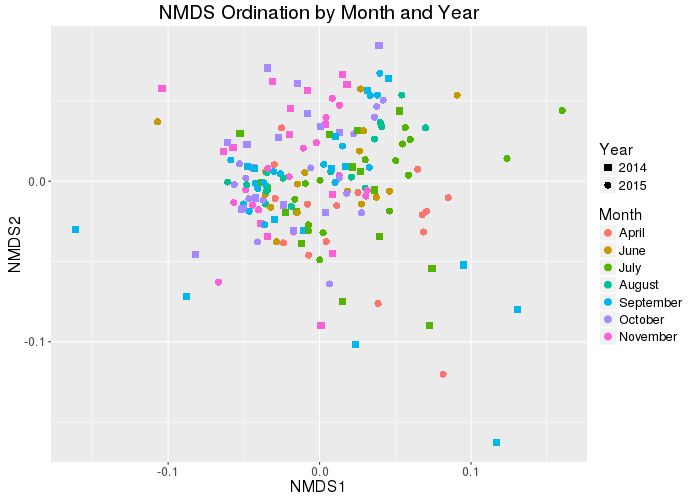

In [31]:
%%R -w 700 -h 500
nmds = ordinate(physeq.Bulk.core.RFN, 
                method = "NMDS", 
                distance = wunif.dist.all)

p.nmds = plot_ordination(physeq.Bulk, nmds, justDF = TRUE)
#print(p)

p.nmds$Month = factor(p.nmds$Month, levels = c("April", "June", "July", "August", "September", "October", "November"))

asNumeric = function(x) { as.numeric(as.character(x)) }

p.nmds1 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point((aes(color = as.factor(Month), shape = as.factor(Year))), size = 3) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        labs(title="NMDS Ordination by Month and Year") + scale_shape_manual(values = c(15,16,17,18), name = "Year") +
        scale_color_discrete(name = "Month") + theme(text = element_text(size = 16))

print(p.nmds1)

In [32]:
%%R
ggsave(filename = "data/figs/Month_Bulk_ord.png", plot = p.nmds1, width =7, height =5)

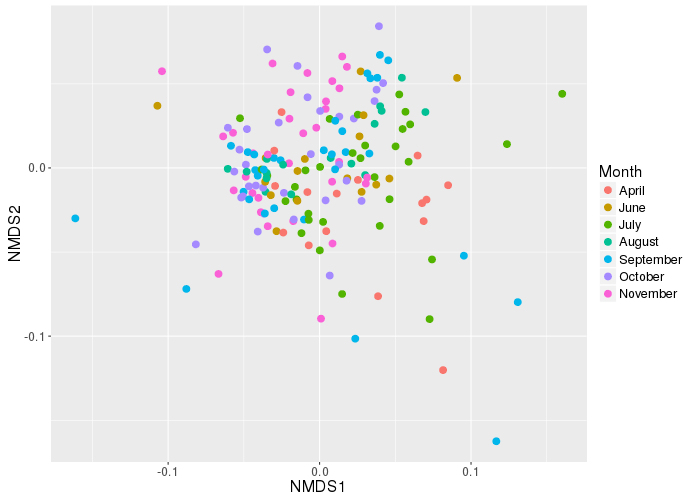

In [33]:
%%R -w 700 -h 500

p.nmds1 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point((aes(color = as.factor(Month))), size = 3) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        scale_shape_manual(values = c(15,16,17,18), name = "Year") +
        scale_color_discrete(name = "Month") + theme(text = element_text(size = 16))

print(p.nmds1)

In [34]:
%%R
ggsave(filename = "data/figs/Monthonly_Bulk_ord.png", plot = p.nmds1, width =8, height =5)

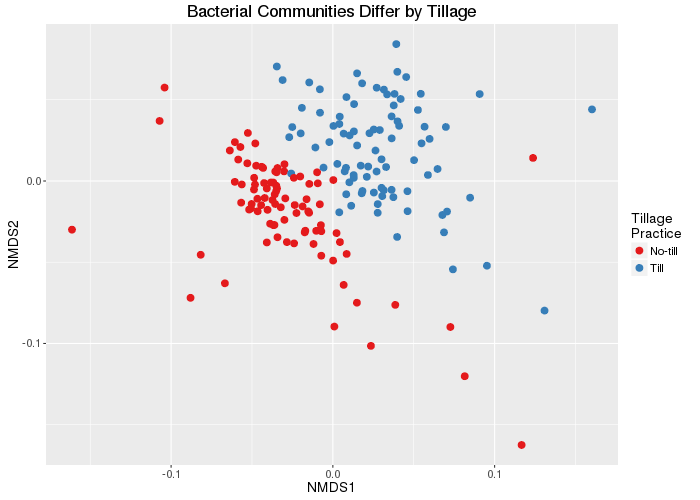

In [35]:
%%R -w 700 -h 500
p.nmds3 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point((aes(color = Till)), size = 3)  +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        labs(title="Bacterial Communities Differ by Tillage")+ theme(text = element_text(size = 14)) #+
        #geom_point(data = subset(p.nmds, Full.sample %in% c('O.PTR.4', 'O.NTR.4')), fill = 'black', size = 2)

p.nmds3 = p.nmds3 + 
    scale_color_brewer(name="Tillage\nPractice", palette = "Set1", labels = c('No-till', 'Till'))

print(p.nmds3)




In [36]:
%%R
ggsave(filename = "data/figs/Till_ord.png", plot = p.nmds3, width =8, height =6)

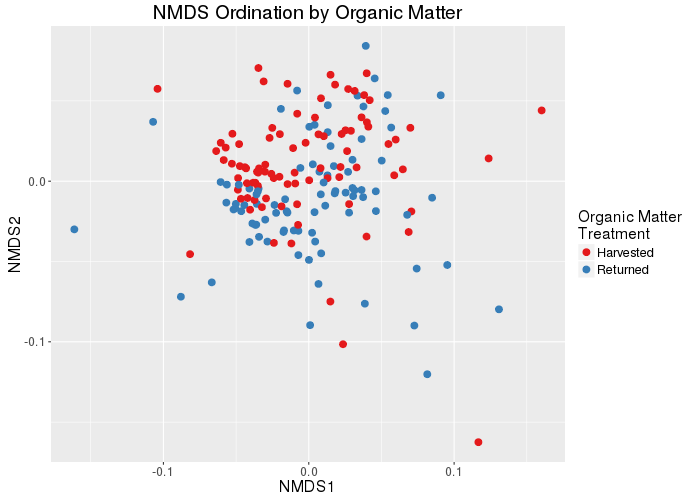

In [37]:
%%R -w 700 -h 500
p.nmds3 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point((aes(color = OM)), size = 3)  +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        labs(title="NMDS Ordination by Organic Matter") + theme(text = element_text(size = 16)) 


p.nmds3 = p.nmds3 + scale_color_brewer(name="Organic Matter\nTreatment", palette = "Set1", 
                                       labels = c('Harvested', 'Returned'))
print(p.nmds3)




In [38]:
%%R
ggsave(filename = "data/figs/OM_ord.png", plot = p.nmds3, width =7, height =5)

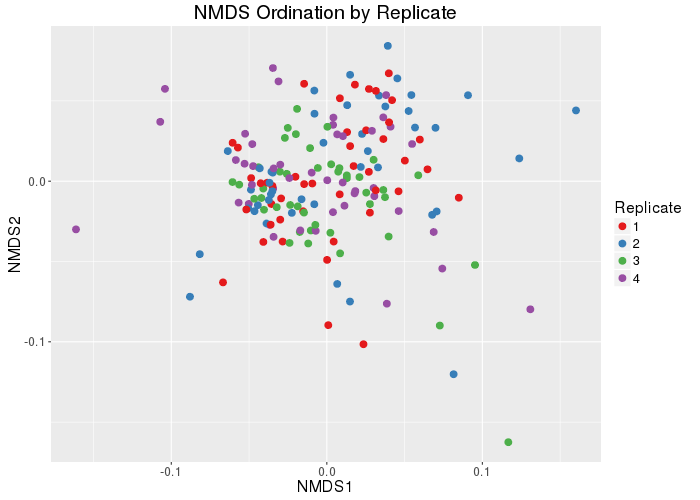

In [39]:
%%R -w 700 -h 500
p.nmds3 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point((aes(color = as.factor(Replicate))), size = 3)  +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        labs(title="NMDS Ordination by Replicate") + theme(text = element_text(size = 16)) 


p.nmds3 = p.nmds3 + scale_color_brewer(name="Replicate", palette = "Set1")



print(p.nmds3)




In [40]:
%%R
ggsave(filename = "data/figs/Replicate_ord.png", plot = p.nmds3, width =7, height =5)

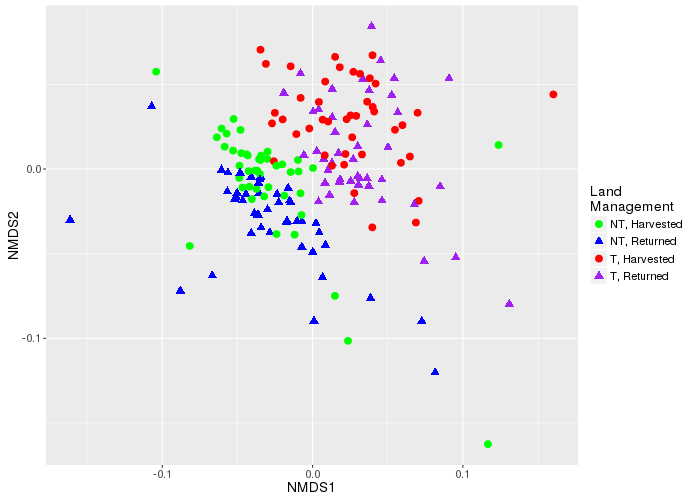

In [41]:
%%R -w 700 -h 500
p.nmds3 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(color = as.factor(Land_Management), shape = Land_Management), size = 3)  +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+ theme(text = element_text(size = 14)) 


p.nmds3 = p.nmds3 + scale_color_manual(name="Land\nManagement", values = c('green', 'blue', 'red', 'purple'), 
                                       labels = c('NT, Harvested', 'NT, Returned', 'T, Harvested', 'T, Returned')) +
                    scale_shape_manual(name="Land\nManagement", values = c(19, 17, 19, 17), 
                                       labels = c('NT, Harvested', 'NT, Returned', 'T, Harvested', 'T, Returned'))

print(p.nmds3)



 

In [42]:
%%R
ggsave(filename = "data/figs/LandManagement_ord.png", plot = p.nmds3, width =8, height =6)

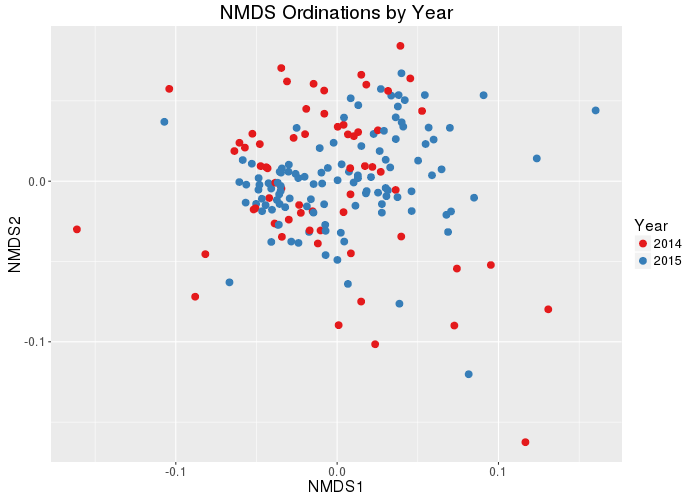

In [43]:
%%R -w 700 -h 500
p.nmds3 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point((aes(color = as.factor(Year))), size = 3)  +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        labs(title="NMDS Ordinations by Year")+ theme(text = element_text(size = 16)) 


p.nmds3 = p.nmds3 + scale_color_brewer(name="Year", palette = "Set1")

print(p.nmds3)





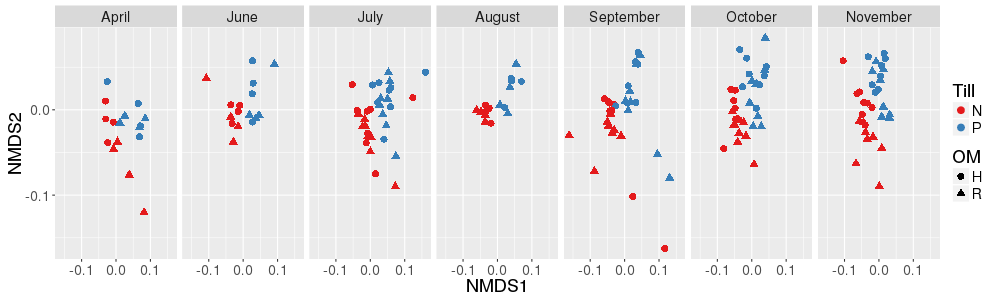

In [44]:
%%R -w 1000 -h 300
p.nmds3 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(color = as.factor(Till), shape = OM), size = 3) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        facet_grid(.~Month)+ theme(text = element_text(size = 18)) 


p.nmds3 = p.nmds3 + scale_color_brewer(name="Till", palette = "Set1")
print(p.nmds3)





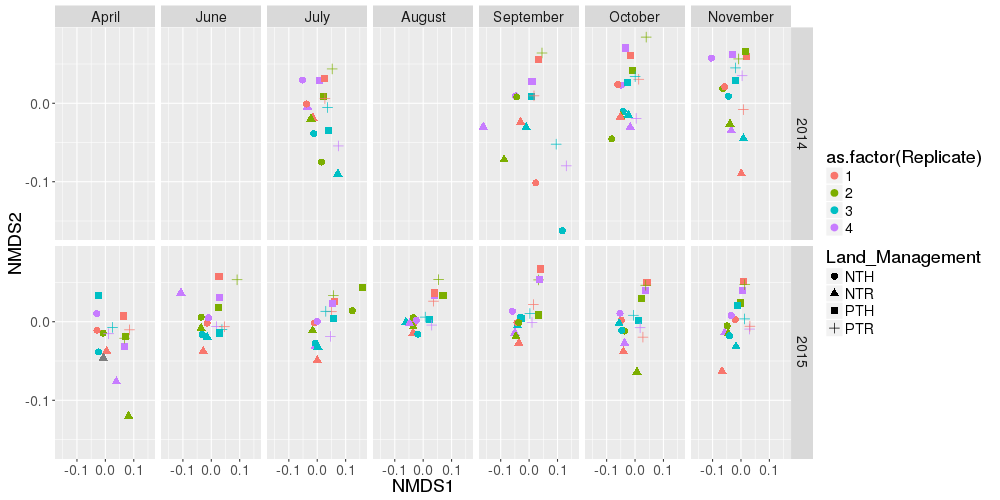

In [45]:
%%R -w 1000 -h 500
p.nmds3 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(color = as.factor(Replicate), shape = Land_Management), size = 3) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        facet_grid(Year~Month)+ theme(text = element_text(size = 18)) 


print(p.nmds3)





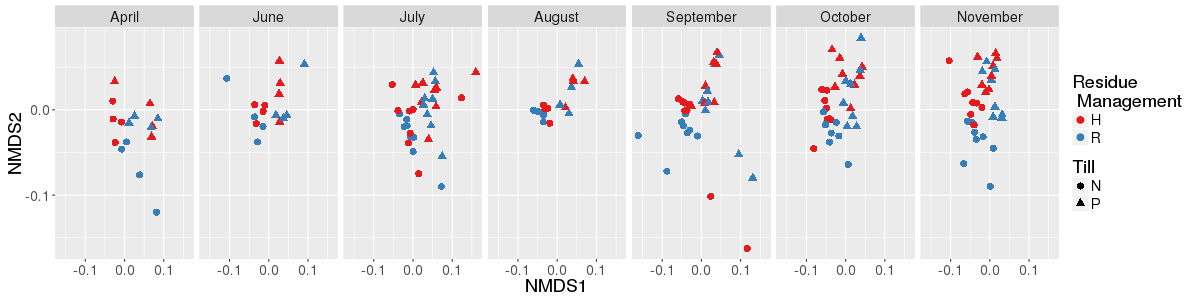

In [46]:
%%R -w 1200 -h 300
p.nmds3 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(color = as.factor(OM), shape = Till), size = 3) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        facet_grid(.~Month)+ theme(text = element_text(size = 18)) 


p.nmds3 = p.nmds3 + scale_color_brewer(name="Residue \n Management", palette = "Set1")
print(p.nmds3)





In [47]:
%%R
ggsave(filename = "data/figs/Facet_Month_ord.png", plot = p.nmds3, width =14, height =4)

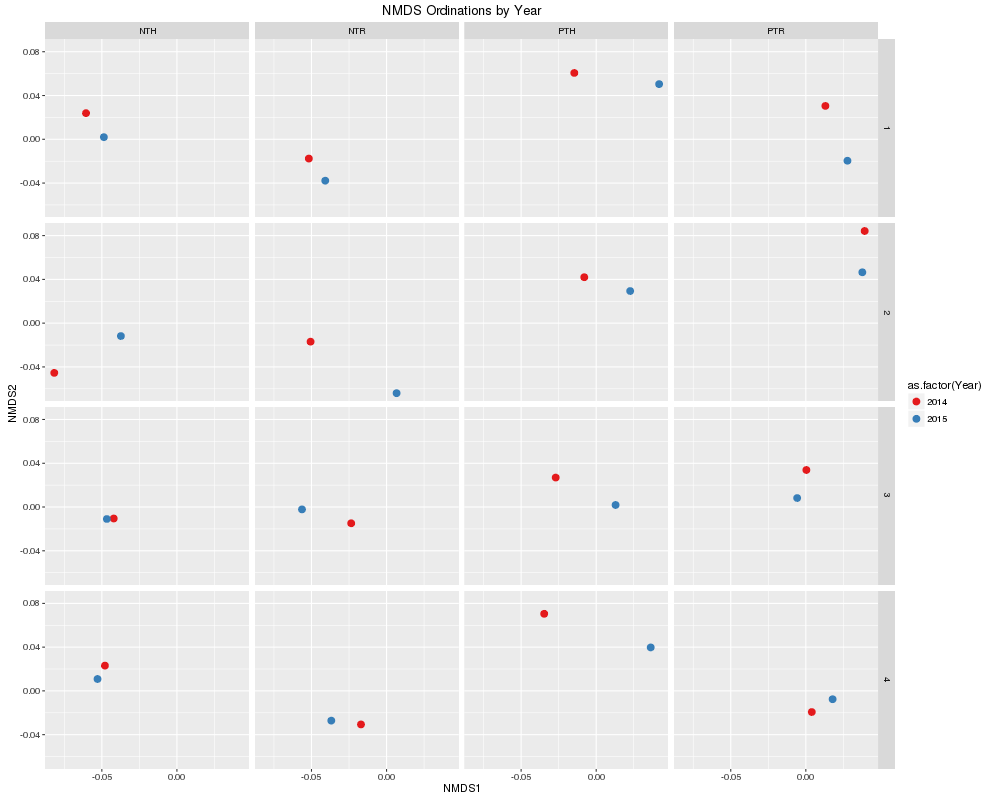

In [48]:
%%R -w 1000 -h 800
p.nmds.Sept = filter(p.nmds, Month == "October")
p.nmds3 = ggplot(p.nmds.Sept, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(color = as.factor(Year)), size = 3) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        labs(title="NMDS Ordinations by Year") + facet_grid(Replicate~Land_Management)

#p.nmds3 = p.nmds3 + geom_point(data = subset(p.nmds2, Year == 2014), shape = 20, size = 2)



p.nmds3 = p.nmds3 + scale_color_brewer(palette="Set1")

print(p.nmds3)





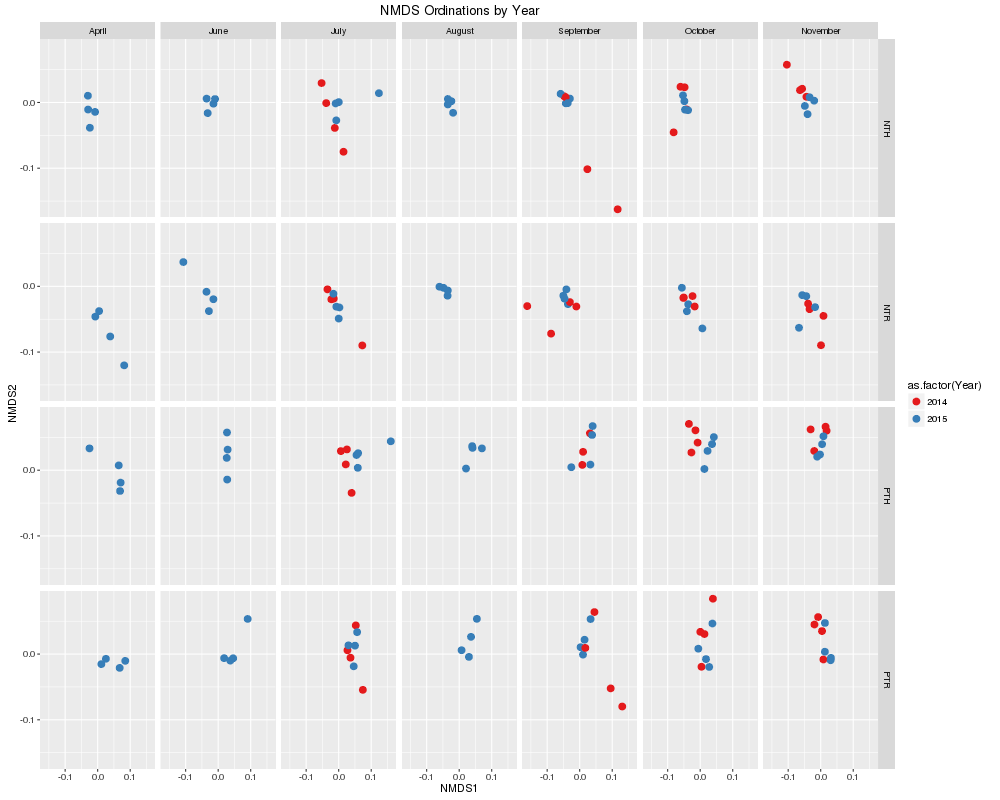

In [49]:
%%R -w 1000 -h 800
p.nmds3 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(color = as.factor(Year)), size = 3) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        labs(title="NMDS Ordinations by Year") + facet_grid(Land_Management~Month)

#p.nmds3 = p.nmds3 + geom_point(data = subset(p.nmds2, Year == 2014), shape = 20, size = 2)



p.nmds3 = p.nmds3 + scale_color_brewer(palette="Set1")

print(p.nmds3)





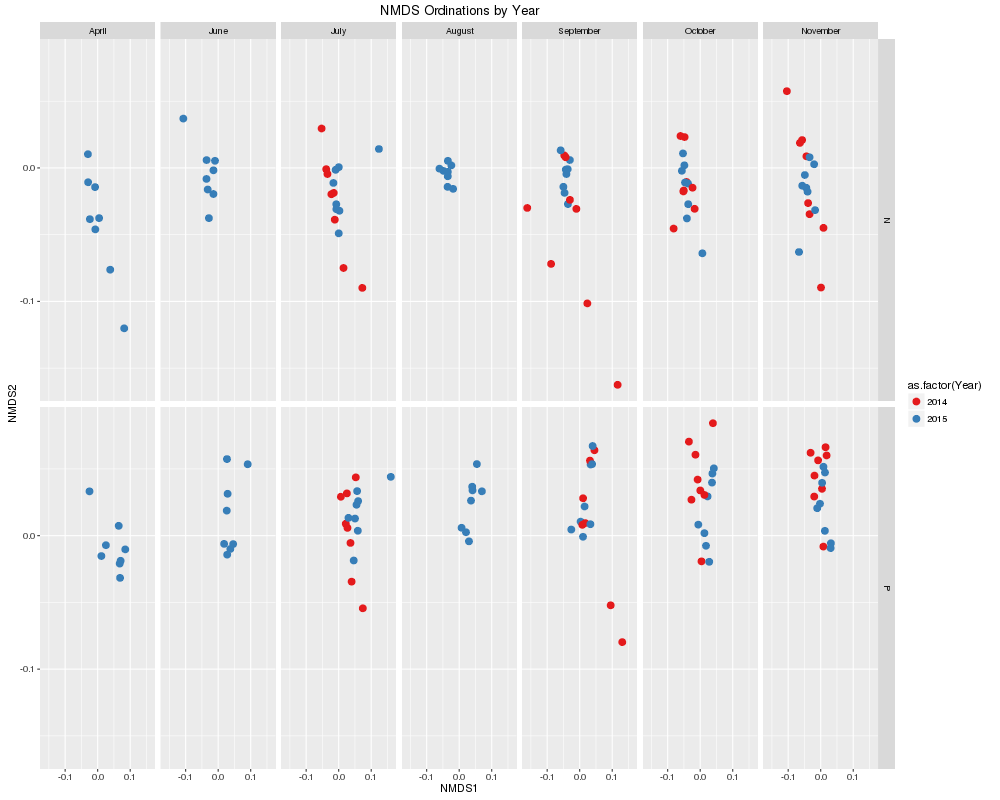

In [50]:
%%R -w 1000 -h 800
p.nmds3 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(color = as.factor(Year)), size = 3) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        labs(title="NMDS Ordinations by Year") + facet_grid(Till~Month)

#p.nmds3 = p.nmds3 + geom_point(data = subset(p.nmds2, Year == 2014), shape = 20, size = 2)



p.nmds3 = p.nmds3 + scale_color_brewer(palette="Set1")

print(p.nmds3)





In [51]:
%%R
ggsave(filename = "data/figs/Facet_MonthAndTill_ord.png", plot = p.nmds3, width =12, height =12)

In [52]:
%%R
p.nmds$MY = paste(p.nmds$Month, p.nmds$Year, sep = '-')
p.nmds$MY = factor(p.nmds$MY, levels = p.nmds$MY[order(p.nmds$Month)])

head(p.nmds)

                     NMDS1        NMDS2    Full.sample Fraction PrimerF PrimerR
Nov.NTR.4.2015 -0.05669818 -0.013319196 Nov.NTR.4.2015       NA    515f    806r
S.NTR.2        -0.08798079 -0.071906616        S.NTR.2       NA    515f    806r
June15.NTH.2   -0.03559583  0.005900306   June15.NTH.2       NA    515f    806r
Oct.NTR.1.2015 -0.04082100 -0.037819262 Oct.NTR.1.2015       NA    515f    806r
July.NTR1      -0.01521134 -0.018686484      July.NTR1       NA    515f    806r
July.NTR4      -0.03451781 -0.004546582      July.NTR4       NA    515f    806r
               Barcode Rev.index Fwd.index Treatment Day Replicate Pool
Nov.NTR.4.2015      84  gtctatga  ctgcgtgt      <NA>  NA         4    8
S.NTR.2            145  tagtctcc  ctactata      <NA>  NA         2    5
June15.NTH.2        84  gtctatga  ctgcgtgt      <NA>  NA         2    4
Oct.NTR.1.2015      46  ctgcgtag  cgtgagtg      <NA>  NA         1    8
July.NTR1          122  actcactg  cgttacta      <NA>  NA         1    5
July.NTR

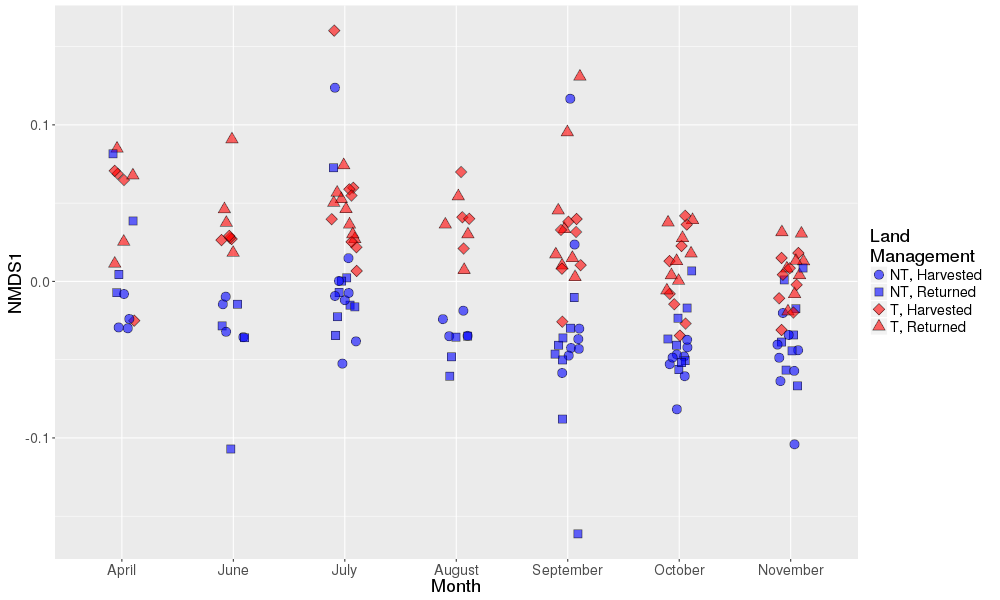

In [53]:
%%R -w 1000 -h 600
p = ggplot(p.nmds, aes(x = Month, y = NMDS1)) + 
    geom_jitter(aes(fill = as.factor(Land_Management),  shape = as.factor(Land_Management)), 
                size = 4, width = 0.3, alpha = 0.6) + 
    scale_shape_manual(name = 'Land\nManagement', values = c(21,22,23,24),
                       labels = c('NT, Harvested', 'NT, Returned', 'T, Harvested', 'T, Returned')) +
    theme(text = element_text(size = 18))+
    scale_fill_manual(name="Land\nManagement", values = c('blue', 'blue', 'red', 'red'), 
                                       labels = c('NT, Harvested', 'NT, Returned', 'T, Harvested', 'T, Returned')) 

p

In [54]:
%%R
ggsave(filename = "data/figs/NMDS1_month_Till.png", plot = p, width =12, height =8)

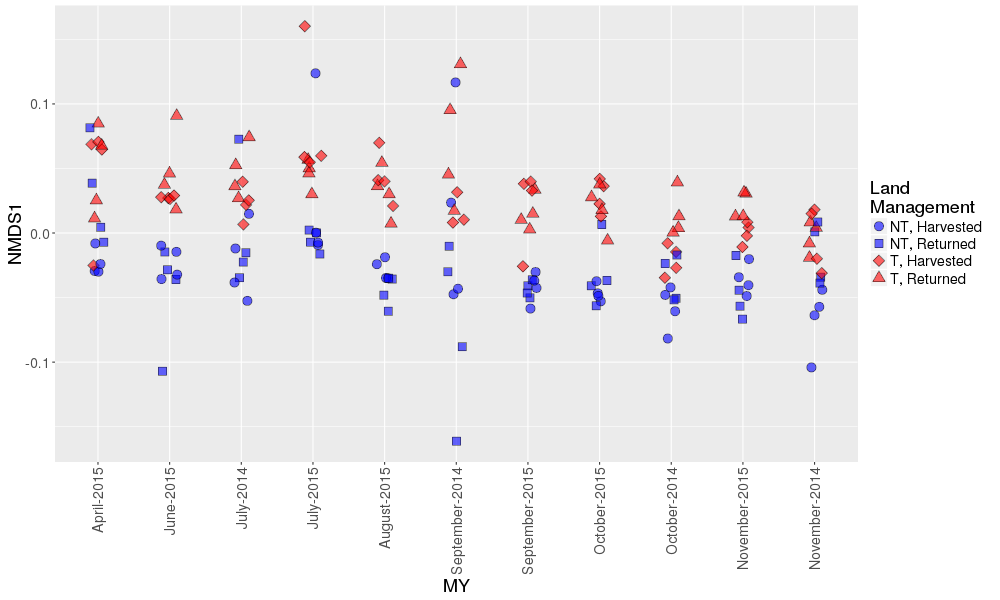

In [55]:
%%R -w 1000 -h 600
p = ggplot(p.nmds, aes(x = MY, y = NMDS1)) + 
    geom_jitter(aes(fill = as.factor(Land_Management),  shape = as.factor(Land_Management)), size = 4, width = 0.3, alpha = 0.6) + 
    scale_shape_manual(name = 'Land\nManagement', values = c(21,22,23,24),
                       labels = c('NT, Harvested', 'NT, Returned', 'T, Harvested', 'T, Returned')) +
    theme(text = element_text(size = 18), axis.text.x = element_text(angle=90, vjust=0.5, hjust=1))+
    scale_fill_manual(name="Land\nManagement", values = c('blue', 'blue', 'red', 'red'), 
                                       labels = c('NT, Harvested', 'NT, Returned', 'T, Harvested', 'T, Returned'))

p

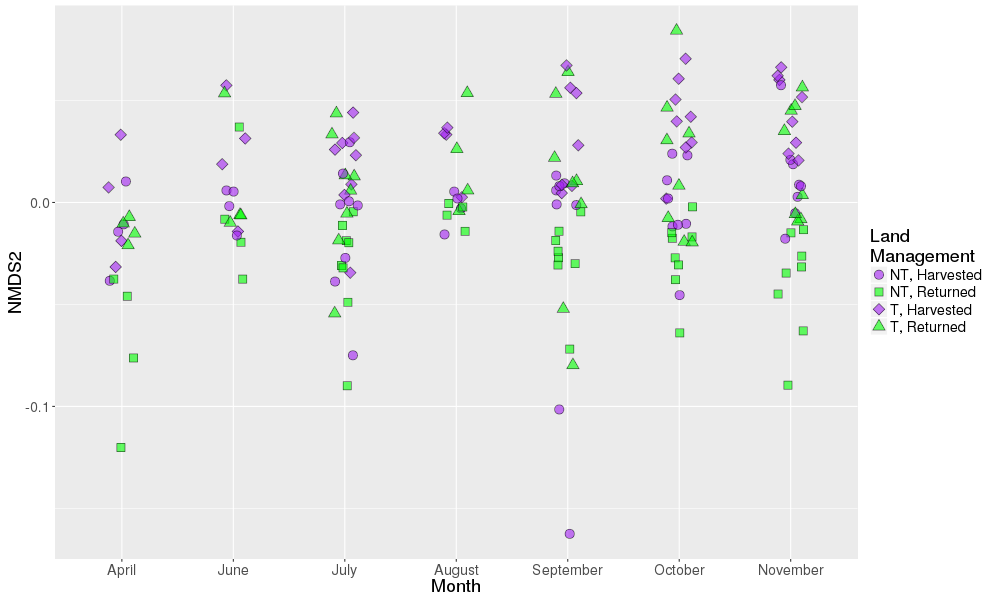

In [56]:
%%R -w 1000 -h 600
p = ggplot(p.nmds, aes(x = Month, y = NMDS2)) + 
    #geom_point(aes(color = as.factor(Till), shape = as.factor(Land_Management)), size = 3) +
    geom_jitter(aes(fill = as.factor(Land_Management), shape = as.factor(Land_Management)), size = 4, width = 0.3, alpha = 0.6) +
    scale_shape_manual(name = 'Land\nManagement', values = c(21,22,23,24),
                       labels = c('NT, Harvested', 'NT, Returned', 'T, Harvested', 'T, Returned')) +
    theme(text = element_text(size = 18))+
    scale_fill_manual(name="Land\nManagement", values = c('purple', 'green', 'purple', 'green'), 
                                       labels = c('NT, Harvested', 'NT, Returned', 'T, Harvested', 'T, Returned'))

  

p

In [57]:
%%R
ggsave(filename = "data/figs/NMDS1_month_OM.png", plot = p, width =12, height =8)

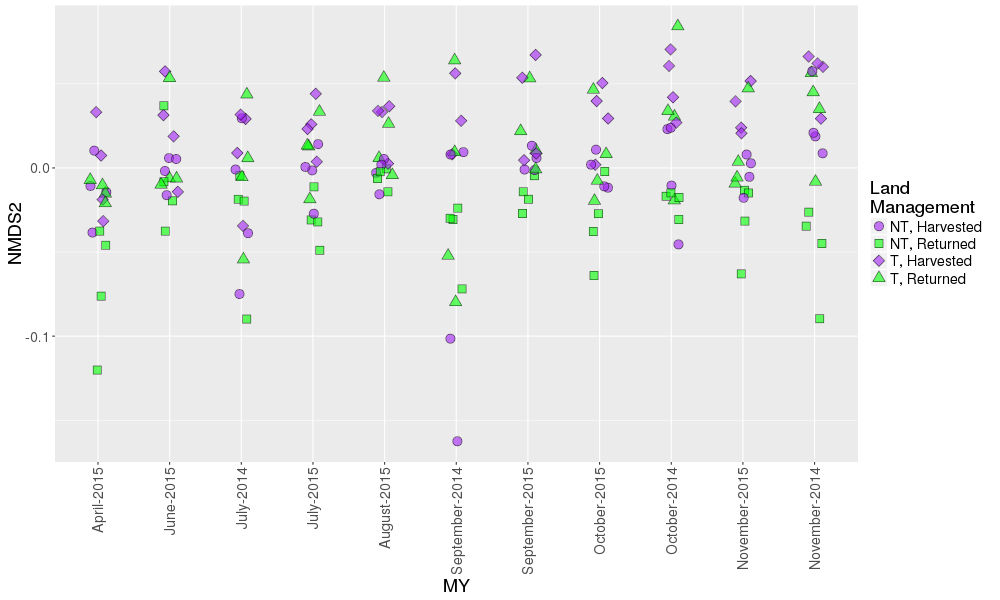

In [58]:
%%R -w 1000 -h 600
p = ggplot(p.nmds, aes(x = MY, y = NMDS2)) + 
    #geom_point(aes(color = as.factor(Till), shape = as.factor(Land_Management)), size = 3) +
    geom_jitter(aes(fill = as.factor(Land_Management), shape = as.factor(Land_Management)), size = 4, width = 0.3, alpha = 0.6) +
    scale_shape_manual(name = 'Land\nManagement', values = c(21,22,23,24),
                       labels = c('NT, Harvested', 'NT, Returned', 'T, Harvested', 'T, Returned')) +
    theme(text = element_text(size = 18), axis.text.x = element_text(angle=90, vjust=0.5, hjust=1))+
    scale_fill_manual(name="Land\nManagement", values = c('purple', 'green', 'purple', 'green'), 
                                       labels = c('NT, Harvested', 'NT, Returned', 'T, Harvested', 'T, Returned'))

  

p

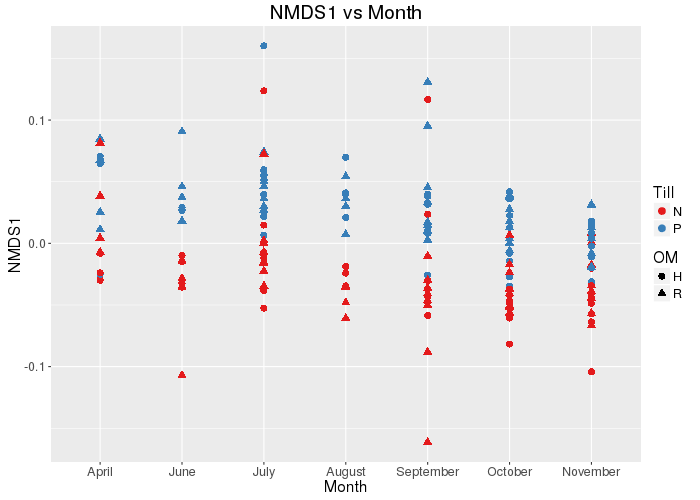

In [59]:
%%R -w 700 -h 500
p.nmds3 = ggplot(p.nmds, aes(x = Month, y = NMDS1)) +  
        geom_point((aes(color = as.factor(Till), shape = OM)), size = 3)  +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        labs(title="NMDS1 vs Month")+ theme(text = element_text(size = 16)) 


p.nmds3 = p.nmds3 + scale_color_brewer(name="Till", palette = "Set1")

print(p.nmds3)

In [60]:
%%R
fit = lm(NMDS1 ~ Month, data=p.nmds)
summary(fit)


Call:
lm(formula = NMDS1 ~ Month, data = p.nmds)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.158178 -0.032862 -0.000209  0.029725  0.135229 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)   
(Intercept)     0.0246427  0.0109623   2.248  0.02588 * 
MonthJune      -0.0231036  0.0155031  -1.490  0.13803   
MonthJuly       0.0003404  0.0134260   0.025  0.97980   
MonthAugust    -0.0241444  0.0155031  -1.557  0.12126   
MonthSeptember -0.0277391  0.0134980  -2.055  0.04142 * 
MonthOctober   -0.0410249  0.0134260  -3.056  0.00261 **
MonthNovember  -0.0435842  0.0134260  -3.246  0.00141 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.04385 on 168 degrees of freedom
Multiple R-squared:  0.1343,	Adjusted R-squared:  0.1033 
F-statistic: 4.342 on 6 and 168 DF,  p-value: 0.0004214



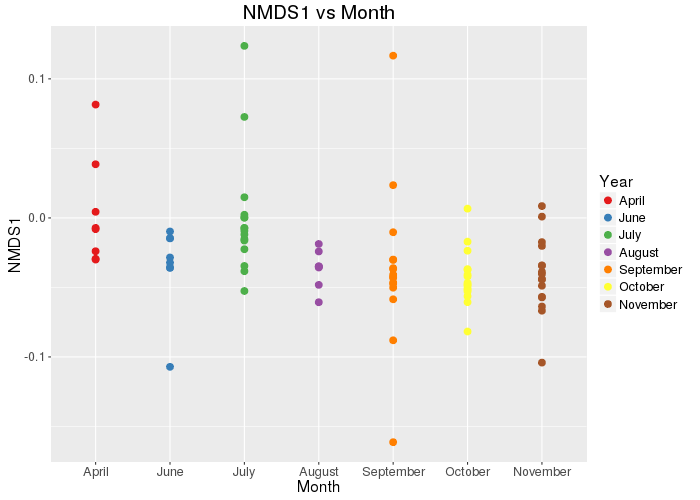

In [61]:
%%R -w 700 -h 500
p.N = filter(p.nmds, Till == 'N')
p.nmds3 = ggplot(p.N, aes(x = Month, y = NMDS1)) +  
        geom_point((aes(color = as.factor(Month))), size = 3)  +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        labs(title="NMDS1 vs Month")+ theme(text = element_text(size = 16)) 


p.nmds3 = p.nmds3 + scale_color_brewer(name="Year", palette = "Set1")

print(p.nmds3)





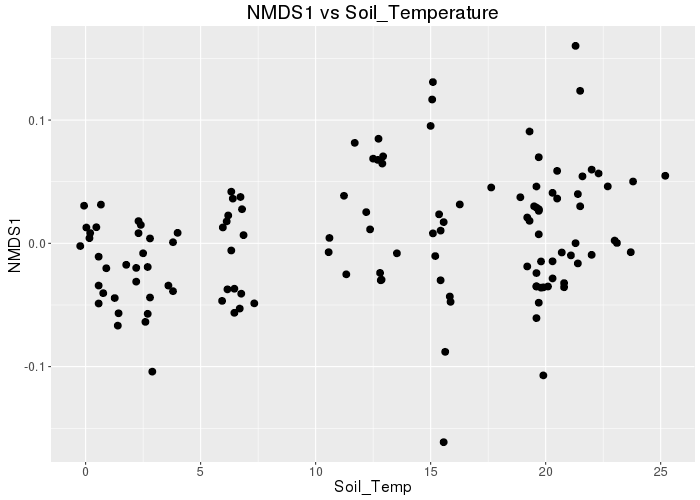

In [62]:
%%R -w 700 -h 500
p.nmds3 = ggplot(p.nmds, aes(x = Soil_Temp, y = NMDS1)) +  
        geom_point(size = 3)  +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        labs(title="NMDS1 vs Soil_Temperature")+ theme(text = element_text(size = 16)) 


p.nmds3 = p.nmds3 + scale_color_brewer(name="Year", palette = "Set1")

print(p.nmds3)


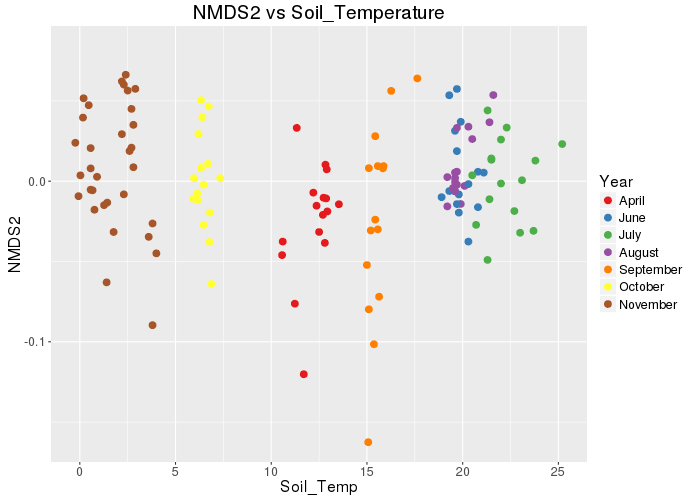

In [63]:
%%R -w 700 -h 500
p.nmds3 = ggplot(p.nmds, aes(x = Soil_Temp, y = NMDS2)) +  
        geom_point((aes(color = as.factor(Month))), size = 3)  +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        labs(title="NMDS2 vs Soil_Temperature")+ theme(text = element_text(size = 16)) 


p.nmds3 = p.nmds3 + scale_color_brewer(name="Year", palette = "Set1")

print(p.nmds3)

In [64]:
%%R
climate = read.csv('data/NOAA_Chazy.csv', header = TRUE)
head(climate)

            STATION                            STATION_NAME     DATE  MDPR
1 GHCND:USW00064776 PLATTSBURGH INTERNATIONAL AIRPORT NY US 20140710 -9999
2 GHCND:USW00064776 PLATTSBURGH INTERNATIONAL AIRPORT NY US 20140711 -9999
3 GHCND:USW00064776 PLATTSBURGH INTERNATIONAL AIRPORT NY US 20140712 -9999
4 GHCND:USW00064776 PLATTSBURGH INTERNATIONAL AIRPORT NY US 20140713 -9999
5 GHCND:USW00064776 PLATTSBURGH INTERNATIONAL AIRPORT NY US 20140714 -9999
6 GHCND:USW00064776 PLATTSBURGH INTERNATIONAL AIRPORT NY US 20140715 -9999
   DAPR PRCP SNWD SNOW TMAX TMIN  TOBS
1 -9999    0    0    0  244  117 -9999
2 -9999    0    0    0  244   94 -9999
3 -9999    0    0    0  278  106 -9999
4 -9999   10    0    0  250  172 -9999
5 -9999    0    0    0  278  156 -9999
6 -9999  117    0    0  250  150 -9999


In [65]:
%%R
timelist = c('2014-07-10', '2014-09-24','2014-10-29','2014-11-26','2015-04-30','2015-06-17','2015-07-16',
               '2015-08-13','2015-09-23', '2015-10-27', '2015-11-25')
date.range = as.POSIXct(strptime(timelist, format = "%Y-%m-%d"))


climate$date = as.POSIXct(strptime(climate$DATE, format = "%Y%m%d"))
climate$tmin = climate$TMIN/10
climate$tmax = climate$TMAX/10
climate$precip = climate$PRCP/10

Platts = filter(climate, STATION_NAME == 'PLATTSBURGH INTERNATIONAL AIRPORT NY US', date %in% date.range) %>%
         select(STATION_NAME, precip, tmax, tmin, date)

head(Platts)

                             STATION_NAME precip tmax tmin       date
1 PLATTSBURGH INTERNATIONAL AIRPORT NY US    0.0 24.4 11.7 2014-07-10
2 PLATTSBURGH INTERNATIONAL AIRPORT NY US    0.0 21.7  6.1 2014-09-24
3 PLATTSBURGH INTERNATIONAL AIRPORT NY US    1.8 15.0  8.3 2014-10-29
4 PLATTSBURGH INTERNATIONAL AIRPORT NY US    2.8  3.9 -2.1 2014-11-26
5 PLATTSBURGH INTERNATIONAL AIRPORT NY US    0.0 17.8  0.6 2015-04-30
6 PLATTSBURGH INTERNATIONAL AIRPORT NY US    0.0 21.7  8.9 2015-06-17


In [66]:
%%R
p.nmds$date = as.POSIXct(strptime(p.nmds$Sample_Date, format = "%m/%d/%y"))
head(p.nmds)

                     NMDS1        NMDS2    Full.sample Fraction PrimerF PrimerR
Nov.NTR.4.2015 -0.05669818 -0.013319196 Nov.NTR.4.2015       NA    515f    806r
S.NTR.2        -0.08798079 -0.071906616        S.NTR.2       NA    515f    806r
June15.NTH.2   -0.03559583  0.005900306   June15.NTH.2       NA    515f    806r
Oct.NTR.1.2015 -0.04082100 -0.037819262 Oct.NTR.1.2015       NA    515f    806r
July.NTR1      -0.01521134 -0.018686484      July.NTR1       NA    515f    806r
July.NTR4      -0.03451781 -0.004546582      July.NTR4       NA    515f    806r
               Barcode Rev.index Fwd.index Treatment Day Replicate Pool
Nov.NTR.4.2015      84  gtctatga  ctgcgtgt      <NA>  NA         4    8
S.NTR.2            145  tagtctcc  ctactata      <NA>  NA         2    5
June15.NTH.2        84  gtctatga  ctgcgtgt      <NA>  NA         2    4
Oct.NTR.1.2015      46  ctgcgtag  cgtgagtg      <NA>  NA         1    8
July.NTR1          122  actcactg  cgttacta      <NA>  NA         1    5
July.NTR

In [67]:
%%R
test = inner_join(p.nmds, Platts, c('date' = 'date'))
head(test)

        NMDS1        NMDS2    Full.sample Fraction PrimerF PrimerR Barcode
1 -0.05669818 -0.013319196 Nov.NTR.4.2015       NA    515f    806r      84
2 -0.08798079 -0.071906616        S.NTR.2       NA    515f    806r     145
3 -0.03559583  0.005900306   June15.NTH.2       NA    515f    806r      84
4 -0.04082100 -0.037819262 Oct.NTR.1.2015       NA    515f    806r      46
5 -0.01521134 -0.018686484      July.NTR1       NA    515f    806r     122
6 -0.03451781 -0.004546582      July.NTR4       NA    515f    806r     125
  Rev.index Fwd.index Treatment Day Replicate Pool Land_Management Gradient
1  gtctatga  ctgcgtgt      <NA>  NA         4    8             NTR     <NA>
2  tagtctcc  ctactata      <NA>  NA         2    5             NTR     <NA>
3  gtctatga  ctgcgtgt      <NA>  NA         2    4             NTH     <NA>
4  ctgcgtag  cgtgagtg      <NA>  NA         1    8             NTR     <NA>
5  actcactg  cgttacta      <NA>  NA         1    5             NTR     <NA>
6  actcactg  acgtct

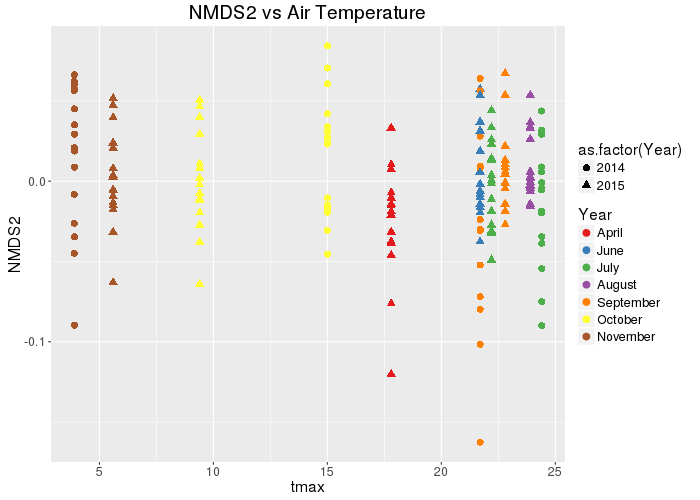

In [68]:
%%R -w 700 -h 500
p.nmds3 = ggplot(test, aes(x = tmax, y = NMDS2)) +  
        geom_point((aes(color = as.factor(Month), shape = as.factor(Year))), size = 3)  +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        labs(title="NMDS2 vs Air Temperature")+ theme(text = element_text(size = 16)) 


p.nmds3 = p.nmds3 + scale_color_brewer(name="Year", palette = "Set1")

print(p.nmds3)


In [69]:
%%R
adonis(wunif.dist ~ tmax, test, na.rm = TRUE)


Call:
adonis(formula = wunif.dist ~ tmax, data = test, na.rm = TRUE) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
tmax        1   0.05541 0.055407  5.4766 0.03069  0.001 ***
Residuals 173   1.75026 0.010117         0.96931           
Total     174   1.80567                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [70]:
%%R
physeq.Bulk.m = physeq.Bulk.core.RFN %>% sample_data()

In [71]:
%%R
physeq.SoilT = prune_samples(!(is.na(physeq.Bulk.m$Soil_Temp)),
                           physeq.Bulk.core.RFN)
    

In [72]:
%%R
physeq.SoilT

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3964 taxa and 127 samples ]
sample_data() Sample Data:       [ 127 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 3964 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3964 tips and 3963 internal nodes ]


In [73]:
%%R
registerDoParallel(cores=20)
wunif.SoilT = distance(physeq.SoilT, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [74]:
%%R
nmds_SoilT = ordinate(physeq.SoilT, 
                method = "NMDS", 
                distance = wunif.SoilT)

Run 0 stress 0.1415999 
Run 1 stress 0.1415996 
... New best solution
... procrustes: rmse 0.0001599513  max resid 0.001653531 
*** Solution reached


In [75]:
%%R
p.nmds_SoilT  = plot_ordination(physeq.SoilT, nmds_SoilT , justDF = TRUE)


In [76]:
%%R
t = dist(p.nmds_SoilT$Soil_Temp)

In [77]:
%%R
length(wunif.SoilT)
length(t)

[1] 8001


In [78]:
%%R
complete = as.data.frame(cbind(wunif.SoilT, t))
head(complete)

  wunif.SoilT         t
1  0.13352784 14.200000
2  0.10280568 19.366667
3  0.08489550  5.333333
4  0.08216574  5.033333
5  0.09105185 18.666667
6  0.11437900  2.166667


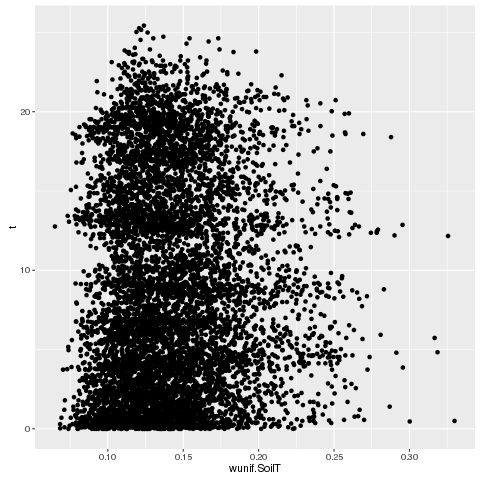

In [79]:
%%R
ggplot(complete, aes(x = wunif.SoilT, y = t)) + geom_point()

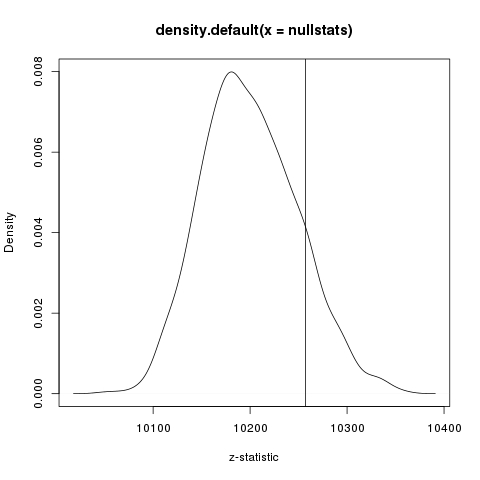

In [80]:
%%R
t2 = as.matrix(t)
wunif.SoilT.m = as.matrix(wunif.SoilT)
man = mantel.test(t2, wunif.SoilT.m, graph = TRUE,
            xlab = "z-statistic", ylab = "Density")

In [81]:
%%R
(man)

$z.stat
[1] 10257.18

$p
[1] 0.259

$alternative
[1] "two.sided"



## Unifrac Similarity in each Treatment - Replicate

In [82]:
%%R
wuni = function(physeq.obj, Land_Management, Replicate) {  
    
    physeq.md = sample_data(physeq.obj)
  
    p = prune_samples((physeq.md$Land_Management == Land_Management) &
                      (physeq.md$Replicate == Replicate), physeq.obj)
   
    wunif.dist = distance(p, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

    df = melt(as.matrix(wunif.dist), varnames = c("Sample1", "Sample2"))

}

    
  

In [83]:
%%R

sdm = physeq.Bulk.core.RFN %>% sample_data %>% 
    filter(! is.na(Replicate)) %>%
    select(Land_Management, Replicate) %>%
    distinct() %>%
    arrange(Land_Management, Replicate) 

sdm %>% nrow %>% print
sdm %>% head(n=5)


[1] 16
  Land_Management Replicate
1             NTH         1
2             NTH         2
3             NTH         3
4             NTH         4
5             NTR         1


In [84]:
%%R
test = sdm %>% head(n=5)

In [85]:
%%R
test

  Land_Management Replicate
1             NTH         1
2             NTH         2
3             NTH         3
4             NTH         4
5             NTR         1


In [86]:
%%R

wuni.l = (mdply(sdm, 
                       wuni, 
                       .parallel = FALSE, 
                       physeq.obj = physeq.Bulk.core.RFN))
head(wuni.l)

  Land_Management Replicate         Sample1        Sample2      value
1             NTH         1  Aug.NTH.1.2015 Aug.NTH.1.2015 0.00000000
2             NTH         1 Sept.NTH.1.2015 Aug.NTH.1.2015 0.07093914
3             NTH         1  Nov.NTH.1.2015 Aug.NTH.1.2015 0.08426032
4             NTH         1       July.NTH1 Aug.NTH.1.2015 0.06831661
5             NTH         1         S.NTH.1 Aug.NTH.1.2015 0.15800067
6             NTH         1   April15.NTH.1 Aug.NTH.1.2015 0.08887979


In [87]:
%%R
test = select(wuni.l, Sample1, Sample2, value)
head(test)

          Sample1        Sample2      value
1  Aug.NTH.1.2015 Aug.NTH.1.2015 0.00000000
2 Sept.NTH.1.2015 Aug.NTH.1.2015 0.07093914
3  Nov.NTH.1.2015 Aug.NTH.1.2015 0.08426032
4       July.NTH1 Aug.NTH.1.2015 0.06831661
5         S.NTH.1 Aug.NTH.1.2015 0.15800067
6   April15.NTH.1 Aug.NTH.1.2015 0.08887979


In [88]:
%%R
wuni.l$Sample = paste(wuni.l$Land_Management, wuni.l$Replicate, sep = ".")

wuni.l$Till[wuni.l$Land_Management %in% c('NTH', 'NTR')] = 'N'
wuni.l$Till[wuni.l$Land_Management %in% c('PTH', 'PTR')] = 'T'

wuni.l$OM[wuni.l$Land_Management %in% c('NTH', 'PTH')] = 'H'
wuni.l$OM[wuni.l$Land_Management %in% c('NTR', 'PTR')] = 'R'

head(wuni.l)

  Land_Management Replicate         Sample1        Sample2      value Sample
1             NTH         1  Aug.NTH.1.2015 Aug.NTH.1.2015 0.00000000  NTH.1
2             NTH         1 Sept.NTH.1.2015 Aug.NTH.1.2015 0.07093914  NTH.1
3             NTH         1  Nov.NTH.1.2015 Aug.NTH.1.2015 0.08426032  NTH.1
4             NTH         1       July.NTH1 Aug.NTH.1.2015 0.06831661  NTH.1
5             NTH         1         S.NTH.1 Aug.NTH.1.2015 0.15800067  NTH.1
6             NTH         1   April15.NTH.1 Aug.NTH.1.2015 0.08887979  NTH.1
  Till OM
1    N  H
2    N  H
3    N  H
4    N  H
5    N  H
6    N  H


In [89]:
%%R
wuni.df = filter(wuni.l, value != 0)

In [90]:
%%R
 #Permanova; centroid size analysis 
fit = adonis(value ~ Till*OM + Replicate, wuni.df)


Error in rowSums(x, na.rm = TRUE) : 
  'x' must be an array of at least two dimensions


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in rowSums(x, na.rm = TRUE) : 
  'x' must be an array of at least two dimensions

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In addition: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Warning messages:

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: replacing previous import ‘BiocGenerics::Position’ by ‘ggplot2::Position’ when loading ‘phyloseq’ 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 2: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib

In [91]:
%%R
summary(fit)


Call:
lm(formula = NMDS1 ~ Month, data = p.nmds)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.158178 -0.032862 -0.000209  0.029725  0.135229 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)   
(Intercept)     0.0246427  0.0109623   2.248  0.02588 * 
MonthJune      -0.0231036  0.0155031  -1.490  0.13803   
MonthJuly       0.0003404  0.0134260   0.025  0.97980   
MonthAugust    -0.0241444  0.0155031  -1.557  0.12126   
MonthSeptember -0.0277391  0.0134980  -2.055  0.04142 * 
MonthOctober   -0.0410249  0.0134260  -3.056  0.00261 **
MonthNovember  -0.0435842  0.0134260  -3.246  0.00141 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.04385 on 168 degrees of freedom
Multiple R-squared:  0.1343,	Adjusted R-squared:  0.1033 
F-statistic: 4.342 on 6 and 168 DF,  p-value: 0.0004214



In [92]:
%%R
fit2 = aov(value ~ Sample + Replicate, data = wuni.df)

In [93]:
%%R
summary(fit2)

              Df Sum Sq  Mean Sq F value Pr(>F)    
Sample        15 0.1208 0.008050   7.517 <2e-16 ***
Residuals   1704 1.8250 0.001071                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [94]:
%%R
NTH1 = filter(wuni.df, sample == 'NTH.1')
ggplot(NTH1, aes(x = Sample2, y = value)) +
  geom_boxplot(fill = "grey80", colour = "blue") +
  scale_x_discrete() + xlab("Sample") +
  ylab("Weighted Unifrac Distance")


Error in eval(expr, envir, enclos) : 
  comparison (1) is possible only for atomic and list types


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in eval(expr, envir, enclos) : 
  comparison (1) is possible only for atomic and list types

  res = super(Function, self).__call__(*new_args, **new_kwargs)


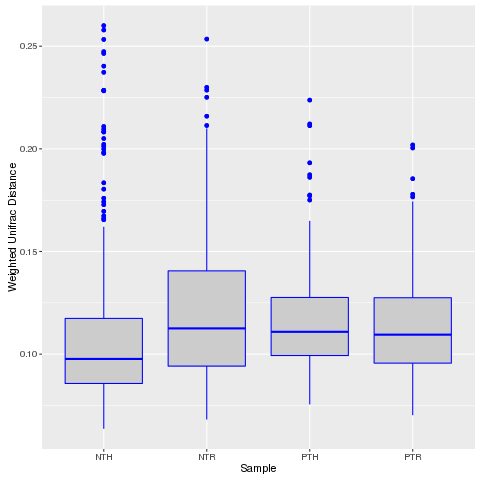

In [95]:
%%R
ggplot(wuni.df, aes(x = Land_Management, y = value)) +
  geom_boxplot(fill = "grey80", colour = "blue") +
  scale_x_discrete() + xlab("Sample") +
  ylab("Weighted Unifrac Distance")

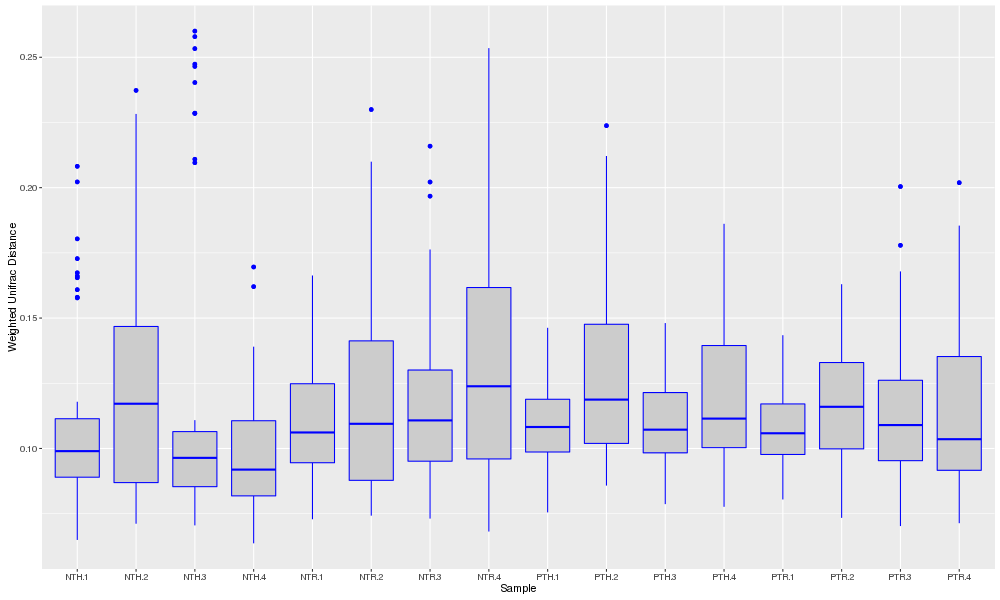

In [96]:
%%R -w 1000 -h 600
ggplot(wuni.df, aes(x = Sample, y = value)) +
  geom_boxplot(fill = "grey80", colour = "blue") +
  scale_x_discrete() + xlab("Sample") +
  ylab("Weighted Unifrac Distance")

In [97]:
%%R
sample_data(physeq.Bulk.core.r)$Month = factor(sample_data(physeq.Bulk.core.r)$Month, 
                                               levels = c("April","June","July","August", "September", "October",
                                                         "November"))



Error in sample_data(physeq.Bulk.core.r) : 
  object 'physeq.Bulk.core.r' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in sample_data(physeq.Bulk.core.r) : 
  object 'physeq.Bulk.core.r' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [98]:
%%R -w 1000 -h 500
plot_richness(physeq.Bulk.core.r, measures = c("Shannon", 'Chao1'), x = 'Month', color = "Land_Management") 



Error in otu_table(physeq) : object 'physeq.Bulk.core.r' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in otu_table(physeq) : object 'physeq.Bulk.core.r' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [99]:
%%R -w 1000 -h 500
plot_richness(physeq.Bulk.core.r, measures = c("Shannon"), x = 'Month', color = "Land_Management") +
facet_wrap(~Year)



Error in otu_table(physeq) : object 'physeq.Bulk.core.r' not found


In [100]:
%%R -w 1000 -h 500
plot_richness(physeq.Bulk.core.r, measures = c("Chao1"), x = 'Month', color = "Land_Management") +
facet_wrap(~Land_Management)



Error in otu_table(physeq) : object 'physeq.Bulk.core.r' not found


In [101]:
%%R -w 1000 -h 500
plot_richness(physeq.Bulk.core.r, measures = c("Shannon"), x = 'Month', color = "Land_Management") +
facet_wrap(~Land_Management)


Error in otu_table(physeq) : object 'physeq.Bulk.core.r' not found


In [102]:
%%R
veganotu = function(physeq) {
    require("vegan")
    OTU = otu_table(physeq)
    if (taxa_are_rows(OTU)) {
        OTU = t(OTU)
    }
    return(as(OTU, "matrix"))
}

In [103]:
%%R
shannon_div = diversity(veganotu(physeq.Bulk.core.r), index = "shannon", MARGIN = 1, base = exp(1))
simpson_div = diversity(veganotu(physeq.Bulk.core.r), index = "simpson", MARGIN = 1, base = exp(1))



Error in otu_table(physeq) : object 'physeq.Bulk.core.r' not found


In [104]:
%%R
sd = as.data.frame(shannon_div) 
simpd = as.data.frame(simpson_div)
sd$Full.sample = rownames(sd)
simpd$Full.sample = rownames(simpd)



physeq.m = physeq.Bulk.core.r %>% sample_data


Error in as.data.frame(shannon_div) : object 'shannon_div' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in as.data.frame(shannon_div) : object 'shannon_div' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [105]:
%%R 
sd.total = left_join(sd, physeq.m)
simpd.total = left_join(simpd, physeq.m)
print(head(sd.total))
print(head(simpd.total))


Error in UseMethod("left_join") : 
  no applicable method for 'left_join' applied to an object of class "function"


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in UseMethod("left_join") : 
  no applicable method for 'left_join' applied to an object of class "function"

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [106]:
%%R
fit_sd = aov(shannon_div ~ Land_Management*Month + Replicate, data = sd.total)
summary(fit_sd)


Error in terms.formula(formula, "Error", data = data) : 
  object 'sd.total' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in terms.formula(formula, "Error", data = data) : 
  object 'sd.total' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [107]:
%%R
fit_sd = aov(shannon_div ~ Till*Month + Replicate, data = sd.total)
summary(fit_sd)


Error in terms.formula(formula, "Error", data = data) : 
  object 'sd.total' not found


In [108]:
%%R
fit_sd = aov(shannon_div ~ OM*Month + Replicate, data = sd.total)
summary(fit_sd)


Error in terms.formula(formula, "Error", data = data) : 
  object 'sd.total' not found


In [109]:
%%R -w 600 -h 400
ggplot(data = sd.total, aes(Land_Management, shannon_div)) + geom_boxplot(aes(color = Land_Management)) + 
     theme(text = element_text(size = 16)) + ylab("Shannon's Diversity") + xlab(NULL)



Error in ggplot(data = sd.total, aes(Land_Management, shannon_div)) : 
  object 'sd.total' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in ggplot(data = sd.total, aes(Land_Management, shannon_div)) : 
  object 'sd.total' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [110]:
%%R
pairwise.t.test(sd.total$shannon_div, sd.total$Land_Management, p.adjust.method = "BH")


Error in factor(g) : object 'sd.total' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in factor(g) : object 'sd.total' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [111]:
%%R
pairwise.t.test(sd.total$shannon_div, sd.total$Month, p.adjust.method = "BH")


Error in factor(g) : object 'sd.total' not found


In [112]:
%%R
fit_simpd = aov(simpson_div ~ Land_Management*Month + Replicate, data = simpd.total)
summary(fit_simpd)


Error in terms.formula(formula, "Error", data = data) : 
  object 'simpd.total' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in terms.formula(formula, "Error", data = data) : 
  object 'simpd.total' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [113]:
%%R
pairwise.t.test(simpd.total$simpson_div, simpd.total$Land_Management, p.adjust.method = "BH")


Error in factor(g) : object 'simpd.total' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in factor(g) : object 'simpd.total' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [114]:
%%R
pairwise.t.test(simpd.total$simpson_div, simpd.total$Month, p.adjust.method = "BH")


Error in factor(g) : object 'simpd.total' not found


## Influence of Time on weighted UniFrac

In [115]:
%%R
library(reshape2)

df = melt(as.matrix(wunif.dist), varnames = c("T1", "T2"))

In [116]:
%%R
head(df)

              T1             T2      value
1 Nov.NTR.4.2015 Nov.NTR.4.2015 0.00000000
2        S.NTR.2 Nov.NTR.4.2015 0.13352784
3   June15.NTH.2 Nov.NTR.4.2015 0.10280568
4 Oct.NTR.1.2015 Nov.NTR.4.2015 0.08489550
5      July.NTR1 Nov.NTR.4.2015 0.10557632
6      July.NTR4 Nov.NTR.4.2015 0.08459175


In [117]:
%%R
physeq.test = sample_data(physeq.Bulk.core)

physeq.test = plyr::rename(physeq.test, c("Full.sample"="T1", "Sample_Date"="SD_T1"))

head(physeq.test)

Sample Data:        [6 samples by 25 sample variables]:
                           T1 Fraction PrimerF PrimerR Barcode Rev.index
Nov.NTR.4.2015 Nov.NTR.4.2015       NA    515f    806r      84  gtctatga
S.NTR.2               S.NTR.2       NA    515f    806r     145  tagtctcc
June15.NTH.2     June15.NTH.2       NA    515f    806r      84  gtctatga
Oct.NTR.1.2015 Oct.NTR.1.2015       NA    515f    806r      46  ctgcgtag
July.NTR1           July.NTR1       NA    515f    806r     122  actcactg
July.NTR4           July.NTR4       NA    515f    806r     125  actcactg
               Fwd.index Treatment Day Replicate Pool Land_Management Gradient
Nov.NTR.4.2015  ctgcgtgt      <NA>  NA         4    8             NTR     <NA>
S.NTR.2         ctactata      <NA>  NA         2    5             NTR     <NA>
June15.NTH.2    ctgcgtgt      <NA>  NA         2    4             NTH     <NA>
Oct.NTR.1.2015  cgtgagtg      <NA>  NA         1    8             NTR     <NA>
July.NTR1       cgttacta      <NA>  NA

In [118]:
%%R
Test = full_join(df, physeq.test, by = 'T1')

In [119]:
%%R
physeq.test2 = plyr::rename(physeq.test, c("T1"="T2", "SD_T1"="SD_T2"))


In [120]:
%%R
Test2 = full_join(Test, physeq.test2, by = 'T2')
print(head(Test))
print(length(Test2$T2))

              T1             T2      value Fraction PrimerF PrimerR Barcode
1 Nov.NTR.4.2015 Nov.NTR.4.2015 0.00000000       NA    515f    806r      84
2        S.NTR.2 Nov.NTR.4.2015 0.13352784       NA    515f    806r     145
3   June15.NTH.2 Nov.NTR.4.2015 0.10280568       NA    515f    806r      84
4 Oct.NTR.1.2015 Nov.NTR.4.2015 0.08489550       NA    515f    806r      46
5      July.NTR1 Nov.NTR.4.2015 0.10557632       NA    515f    806r     122
6      July.NTR4 Nov.NTR.4.2015 0.08459175       NA    515f    806r     125
  Rev.index Fwd.index Treatment Day Replicate Pool Land_Management Gradient
1  gtctatga  ctgcgtgt      <NA>  NA         4    8             NTR     <NA>
2  tagtctcc  ctactata      <NA>  NA         2    5             NTR     <NA>
3  gtctatga  ctgcgtgt      <NA>  NA         2    4             NTH     <NA>
4  ctgcgtag  cgtgagtg      <NA>  NA         1    8             NTR     <NA>
5  actcactg  cgttacta      <NA>  NA         1    5             NTR     <NA>
6  actcactg 

In [121]:
%%R
Test2 = Test2 %>% select(T1, T2, value, SD_T1, SD_T2)

In [122]:
%%R
Test2$SD_T1 = as.POSIXct(strptime(Test2$SD_T1, format = "%m/%d/%y"))
Test2$SD_T2 = as.POSIXct(strptime(Test2$SD_T2, format = "%m/%d/%y"))

head(Test2)

              T1             T2      value      SD_T1      SD_T2
1 Nov.NTR.4.2015 Nov.NTR.4.2015 0.00000000 2015-11-25 2015-11-25
2        S.NTR.2 Nov.NTR.4.2015 0.13352784 2014-09-24 2015-11-25
3   June15.NTH.2 Nov.NTR.4.2015 0.10280568 2015-06-17 2015-11-25
4 Oct.NTR.1.2015 Nov.NTR.4.2015 0.08489550 2015-10-27 2015-11-25
5      July.NTR1 Nov.NTR.4.2015 0.10557632 2014-07-10 2015-11-25
6      July.NTR4 Nov.NTR.4.2015 0.08459175 2014-07-10 2015-11-25


In [123]:
%%R
Test2$Day = abs(round(difftime(Test2$SD_T1, Test2$SD_T2, 
         units = "days")))

Test2$Day_rel = as.numeric(Test2$Day)

head(Test2)

              T1             T2      value      SD_T1      SD_T2      Day
1 Nov.NTR.4.2015 Nov.NTR.4.2015 0.00000000 2015-11-25 2015-11-25   0 days
2        S.NTR.2 Nov.NTR.4.2015 0.13352784 2014-09-24 2015-11-25 427 days
3   June15.NTH.2 Nov.NTR.4.2015 0.10280568 2015-06-17 2015-11-25 161 days
4 Oct.NTR.1.2015 Nov.NTR.4.2015 0.08489550 2015-10-27 2015-11-25  29 days
5      July.NTR1 Nov.NTR.4.2015 0.10557632 2014-07-10 2015-11-25 503 days
6      July.NTR4 Nov.NTR.4.2015 0.08459175 2014-07-10 2015-11-25 503 days
  Day_rel
1       0
2     427
3     161
4      29
5     503
6     503


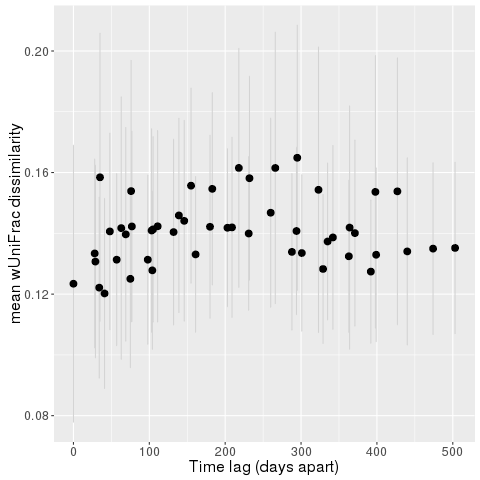

In [124]:
%%R

Test3 = Test2 %>% group_by(Day_rel) %>% summarise(meanval = mean(value), sdval = sd(value))

limits <- aes(ymax = meanval + sdval, ymin = meanval - sdval)


p = ggplot(data = Test3, aes(Day_rel, meanval)) + geom_errorbar(limits, color = 'light grey')+ geom_point(size = 3) +
    xlab('Time lag (days apart)') + ylab('mean wUniFrac dissimilarity') + 
    theme(text = element_text(size = 16)) 
p

In [125]:
%%R
physeq.test = sample_data(physeq.Bulk.core)

physeq.test$Sample_Date = as.POSIXct(strptime(physeq.test$Sample_Date , format = "%m/%d/%y"))

physeq.test$day = round(difftime(physeq.test$Sample_Date, min(physeq.test$Sample_Date), units = "days"))

physeq.test$d = as.numeric(physeq.test$day)
time_d = dist(physeq.test$d)

In [126]:
%%R
library(ecodist)
mantel(formula = wunif.dist ~ time_d, nperm = 10000)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘ecodist’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:vegan’:

    mantel


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:phyloseq’:

    distance


  res = super(Function, self).__call__(*new_args, **new_kwargs)


   mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
0.06363126 0.00840000 0.99170000 0.01060000 0.04273599 0.08562256 
